In [87]:
from pathlib import Path
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix
import optuna
from sklearn.metrics import classification_report


In [124]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [153]:
train_date = pd.read_csv('C:/Users/wgkdj/smbc_comp/data/train.csv')
test_date = pd.read_csv('C:/Users/wgkdj/smbc_comp/data/test.csv')
sub_df = pd.read_csv('C:/Users/wgkdj/smbc_comp/data/sample_submission.csv',header=None)
sub_df.columns = ["index", "health"]

In [90]:
sub_df.shape

(19702, 2)

In [91]:
train_date['health']

0        1
1        1
2        2
3        0
4        1
        ..
19979    2
19980    1
19981    0
19982    1
19983    1
Name: health, Length: 19984, dtype: int64

In [92]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):

        return X

class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")
        
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols
class AggTransformer(TransformerMixin, BaseEstimator):
    """集約特徴量"""

    def __init__(self, key, numeric_cols, agg_func: dict):
        self.key = key
        self.numeric_cols = numeric_cols
        self.agg_func = agg_func

    def fit(self, X, y=None):
        X = X.copy()
        X[self.key] = X[self.key].astype("category")
        self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]

        return self

    def transform(self, X):
        X_new = pd.merge(X, self.agg_df, on=self.key, how="left")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.agg_df.columns.tolist()

In [130]:
import category_encoders as ce


# Assuming OriginalTransformer and PreProcessTransformer are defined

# Sample data

numeric_cols = [
    'tree_dbh',
    'borocode',
    'boro_ct',
    'cb_num',
    'st_senate',
    'st_assem',
    'cncldist',
]
categorical_cols = [
    'curb_loc',
    'steward',
    'guards',
    'sidewalk',
    'user_type',
    'problems',
    'spc_common',
    'spc_latin',
    'nta',
    'nta_name',
    'boroname',
    'zip_city',
]

# ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            numeric_cols + categorical_cols
        ),
        """ (
            "tgt",
            ce.TargetEncoder(cols=['curb_loc', 'steward', 'guards', 'sidewalk', 'user_type', 'problems',
                                   'spc_common', 'spc_latin', 'nta', 'nta_name', 'boroname', 'zip_city']),
            ['curb_loc', 'steward', 'guards', 'sidewalk', 'user_type', 'problems',
             'spc_common', 'spc_latin', 'nta', 'nta_name', 'boroname', 'zip_city']
        ),"""
    ],
    verbose=True
)

# Pipeline
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ('ct', ct),
    ]
)
# Fit and transform
train_feat_df = pipe.fit_transform(train_date, train_date['health'])
test_feat_df = pipe.transform(test_date)


ValueError: too many values to unpack (expected 3)

In [129]:
train_feat_df.head()

,ori__tree_dbh,ori__borocode,ori__boro_ct,ori__cb_num,ori__st_senate,ori__st_assem,ori__cncldist,ori__curb_loc,ori__steward,ori__guards,ori__sidewalk,ori__user_type,ori__problems,ori__spc_common,ori__spc_latin,ori__nta,ori__nta_name,ori__boroname,ori__zip_city
0,14.0,4.0,4152901.0,411.0,11.0,25.0,23.0,OnCurb,NaN,NaN,Damage,Volunteer,NaN,English oak,Quercus robur,QN45,Douglas Manor-Douglaston-Little Neck,Queens,Little Neck
1,5.0,2.0,2039901.0,207.0,33.0,78.0,15.0,OnCurb,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,Acer platanoides 'Crimson King',BX05,Bedford Park-Fordham North,Bronx,Bronx
2,26.0,5.0,5017011.0,503.0,24.0,62.0,51.0,OnCurb,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,Quercus robur,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,Staten Island,Staten Island
3,15.0,5.0,5024401.0,503.0,24.0,62.0,51.0,OnCurb,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,Gleditsia triacanthos var. inermis,SI11,Charleston-Richmond Valley-Tottenville,Staten Island,Staten Island
4,23.0,1.0,1022102.0,110.0,30.0,70.0,9.0,OnCurb,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,Platanus x acerifolia,MN03,Central Harlem North-Polo Grounds,Manhattan,New York


In [95]:
def plot_confusion_matrix(test_y, pred_y, class_names, normalize=False):
        cm = confusion_matrix(test_y, pred_y)
        classes = class_names
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=classes,
            yticklabels=classes,
            ylabel='True label\n',
            xlabel='\nPredicted label')
        fmt = '.2f' if normalize else 'd'
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center")
        fig.tight_layout()
        return ax

In [136]:
def get_statified_cv(df,y,n_fold=5):
    kf = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=2023)
    return list(kf.split(df,y))
def get_cv(df, n_fold=6):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    score_list = []
    models = []
    n_records = len(X)
    recall_list = []
    precision_list = []

    oof = np.zeros((n_records,), dtype=np.int32)
    for fold_, (train_index, valid_index) in enumerate(cv):
        train_x = X.iloc[train_index]
        valid_x = X.iloc[valid_index]
        train_y = y.iloc[train_index]
        valid_y = y.iloc[valid_index]
        print(train_y)
        print(valid_y.head())
        gbm = lgb.LGBMClassifier(**params)
        gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],
                callbacks=[lgb.early_stopping(100, verbose=verbose)], )
        pred_i = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)
        oof[valid_index] = pred_i
        print(pred_i)
        score_list.append(round(f1_score(valid_y, pred_i, average='macro'), 2))
        recall_list.append(round(recall_score(valid_y, pred_i,average='macro'), 2))
        precision_list.append(round(precision_score(valid_y, pred_i,average='macro'), 2))
        models.append(gbm)  # Store the trained model in the list
        print(f'fold{fold_ + 1} end\n')
        print(score_list, 'f1_score', np.mean(score_list))
        print(precision_list, 'precision', np.mean(precision_list))
        print(recall_list, 'recall', np.mean(recall_list))
        plot_confusion_matrix(valid_y, pred_i,[0,1,2])
    return models, oof, gbm
def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax



[(array([    0,     1,     2, ..., 19981, 19982, 19983]), array([    3,    11,    14, ..., 19969, 19973, 19977])), (array([    0,     1,     2, ..., 19978, 19980, 19981]), array([    8,    10,    12, ..., 19979, 19982, 19983])), (array([    0,     1,     2, ..., 19981, 19982, 19983]), array([    4,     7,    13, ..., 19972, 19976, 19978])), (array([    1,     3,     4, ..., 19980, 19982, 19983]), array([    0,     2,     9, ..., 19964, 19970, 19981])), (array([    0,     2,     3, ..., 19981, 19982, 19983]), array([    1,     5,     6, ..., 19959, 19960, 19980]))]
0        1
1        1
2        2
4        1
5        1
6        1
7        0
8        1
9        1
10       1
12       1
13       1
15       1
17       1
18       2
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
31       1
32       0
33       1
34       1
37       1
38       1
39       1
40       1
41       1
42       1
43       1
45       1
46       1


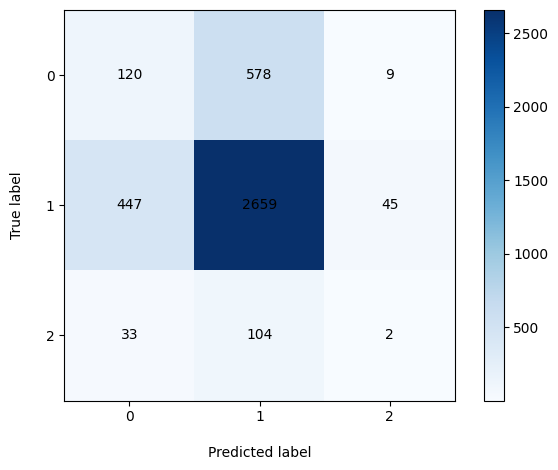

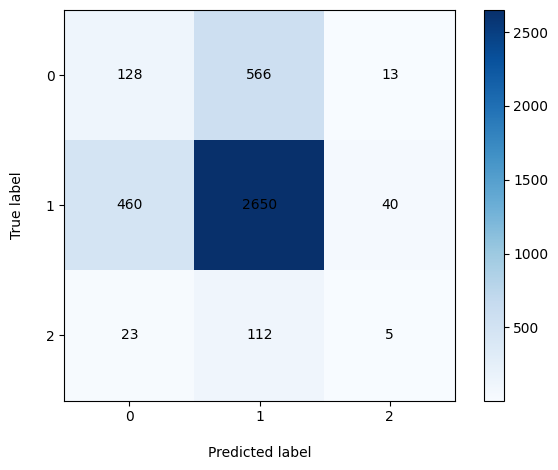

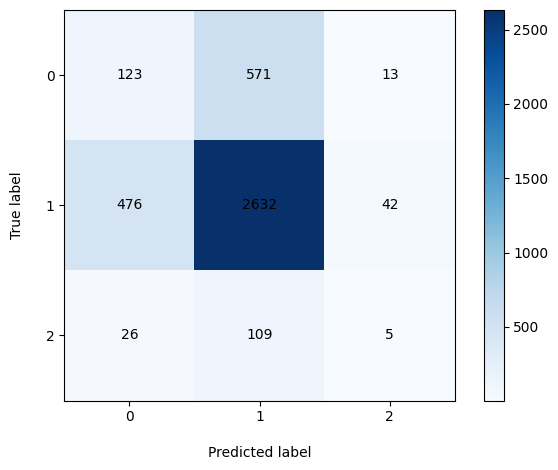

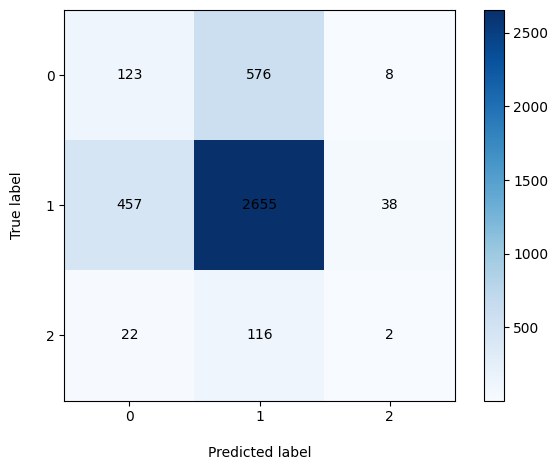

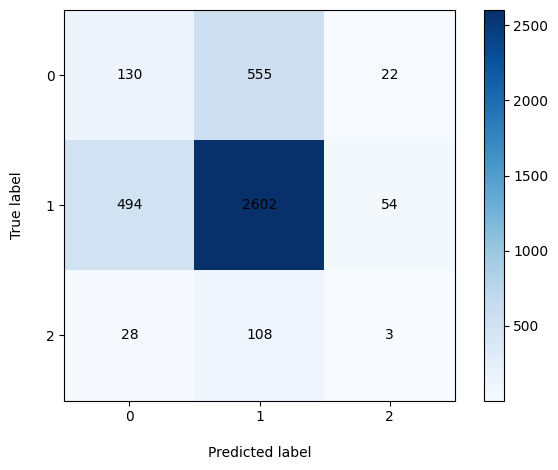

In [143]:
n_fold = 5
lgbm_params = {
    'objective': 'multiclass',
    'num_class': 3,  # クラスの数を指定
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'class_weight': {0: 3, 1: 1, 2: 5},
    
}
# {'max_depth': 10, 'num_leaves': 878, 'colsample_bytree': 0.2694887336706078, 'subsample': 0.6660561803917702, 'class_weight_1': 2.5295377831337054}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_statified_cv(df=train_feat_df,y=train_date['health'], n_fold=5)
#cv = get_cv(df=train_feat_df,n_fold=5)
print(cv)
# training

models,oof,gbm = fit_lgbm(
    train_feat_df,
    y=train_date["health"],
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Importance'}, xlabel='feature_importance', ylabel='column'>)

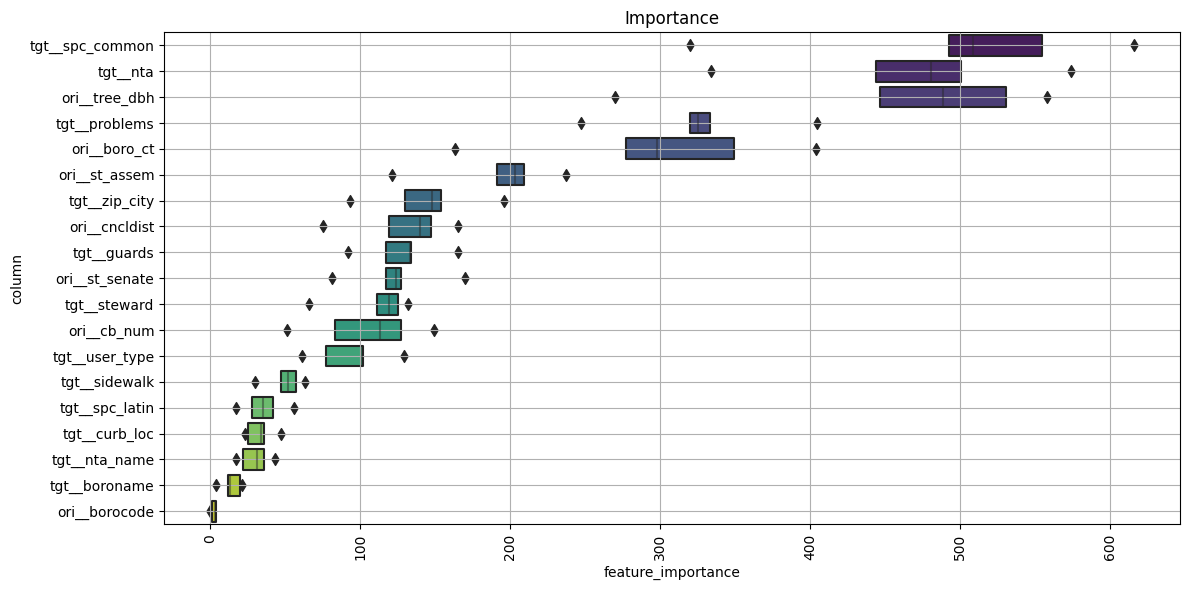

In [98]:
visualize_importance(models,train_feat_df)

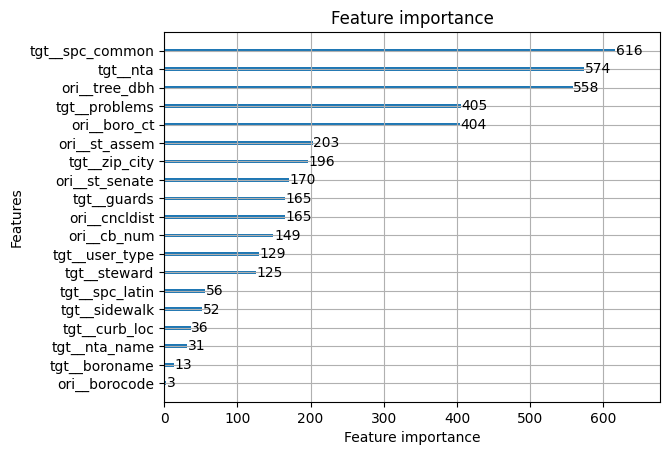

In [99]:
lgb.plot_importance(gbm)

# 新しい図を作成してサイズを調整
#plt.rcParams["figure.figsize"] = [30,30.0] # 幅10、高さ8の図を作成

# プロットを表示
plt.show()

In [151]:
sub_df.columns

Index([0, 1, '1'], dtype='object')

In [149]:
sub_df.sample(5)

,0,1
1553,21571,0
16215,36438,1
18576,38823,1
5647,25715,2
13651,33845,2


In [154]:
# inference
pred = np.array([model.predict_proba(test_feat_df) for model in models])
pred = np.mean(pred, axis=0)
pred_classes = np.argmax(pred, axis=1)  # 各サンプルにおいて確率が最も高いクラスを選択
# 3値分類に変更
pred_classes = pred_classes.astype(int)

# submission
sub_df["health"] = pred_classes
sub_df.to_csv("submission.csv", index=False, header=False)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
